In [3]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

In [4]:
BREAST_CANCER = 'data/mine/breast_cancer.csv'
HEART_FAILURE = 'data/mine/heart_failure.csv'
MEDICAL_INSURANCE = 'data/mine/insurance.csv'
TELCO_CUST_CHURN = 'data/mine/telco-churn.csv'
LUNG_CAP = 'data/mine/LungDisease.csv'
HOUSE_CSV = 'data/mine/house_sales.csv'

# Regression and Prediction 
Perhaps the most common goal in statistics is to answer is the question "Is the variable X or(X1,X2,..,Xn) associated with a variable Y.
<br>
Regression is a way to model this realtionship and the main goal histroically is to be used for profiling.
---
In this chapter will discuss what is regression, How to asses teh model, Confidnce and rediction intervals, Factoring variables, Interpreting the regression equation and Regression diagnostics.

# Simple linear Regression

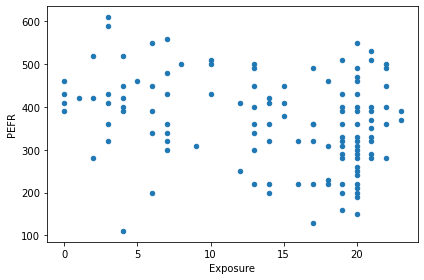

In [5]:
lung_df = pd.read_csv(LUNG_CAP)

lung_df.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

In [9]:
predictors = np.array(lung_df.Exposure)
target = np.array(lung_df.PEFR)

In [10]:
predictors = predictors.reshape(-1,1)
target = target.reshape(-1,1)

In [11]:
LrModel = LinearRegression()
LrModel.fit(predictors,target)

print('Intercept: ',LrModel.intercept_)
print('Estimated Exposure Coefficient: ',LrModel.coef_)

Intercept:  [424.58280657]
Estimated Exposure Coefficient:  [[-4.18457649]]


This can be interpreted as the predicted PER for a worker with zero years of exposure is equal to 424(the intercept) and every year the worker exposed to cotten industry the PER reduced by -4.18

### Fitted values & Residuals illusration

Redisuals are predicted(fitted) values substracted from original values.
<br>
In general the data does not fall exactly on a line, so the regression equation should include an explicit error term:<br>
Yi = b0 + b1Xi + ei

In [13]:
predicted = LrModel.predict(predictors)

In [14]:
residuals = target - predictors

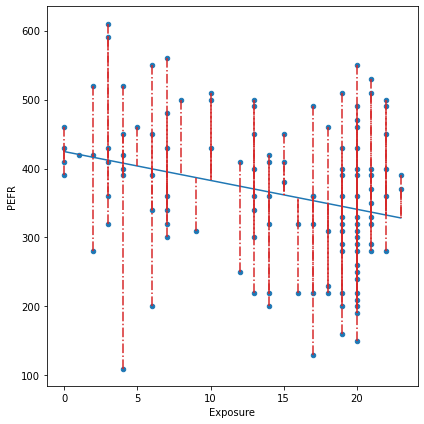

In [17]:
ax = lung_df.plot.scatter(x='Exposure', y='PEFR', figsize=(6, 6))
ax.plot(lung_df.Exposure, predicted)
for x, yactual, yfitted in zip(predictors, target, predicted): 
    ax.plot((x, x), (yactual, yfitted), '-.', color='C3')

plt.tight_layout()
plt.show()

## Multiple Linear Regression
When there are multipe predictors, the equation of simple linear regression extended to accomdate them.

In [19]:
subset = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house = pd.read_csv(HOUSE_CSV, sep='\t')
house[subset].head()

,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade
1,2400,9373,3.00,6,7
2,3764,20156,3.75,4,10
3,2060,26036,1.75,4,8
4,3200,8618,3.75,5,7
5,1720,8620,1.75,4,7


The goal is to predict the sale price using other variables.

In [20]:
house_lm = LinearRegression()
house_lm.fit(house[subset], house[outcome])

LinearRegression()

In [34]:
print(f'The model intercept {house_lm.intercept_:.2f}')
print('Coefficients:')
for name, coeff in zip(subset,house_lm.coef_):
    print(f'{name :} {coeff:.2f}')

The model intercept -521871.37
Coefficients:
SqFtTotLiving 228.83
SqFtLot -0.06
Bathrooms -19442.84
Bedrooms -47769.96
BldgGrade 106106.96


This can be interpreted as adding another sqFt to a house increase its price by 228$ while the other predictors remains the same.

## Assessing the Model 

The most important performance metric to datascientists is RMSE there is another variation of it called RSE is simply the same in the dominator we substracting the degree of freedom in practice the difference is small, specially for the big data applicatoins

In [35]:
fitted = house_lm.predict(house[subset])
RMSE = np.sqrt(mean_squared_error(house[outcome],fitted))
print(f'RMSE :{RMSE:.1f}')

RMSE :261220.2


Another metric is R2 ranges from 0 to 1 and
measures the proportion of variation in the data that is accounted for in the model.<br> It
is useful mainly in explanatory uses of regression where you want to assess how well
the model fits the data.<br>
In other words how good our model fits data respect to the mean model.

In [36]:
r2 = r2_score(house[outcome], fitted)
print(f'R2 :{r2:.2f}')

R2 :0.54


We can get a detailed analysis for our regression model 

In [49]:
model = sm.OLS(np.array(house[outcome]).reshape(-1,1), np.array(house[subset].assign(const=1)).reshape(-1,6))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Sun, 28 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:37:26   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           228.8306      3.899     58.694      0.000     221.189     236.472
x2            -0.0605      0.061     -0.988      0.323      -0.180       0.059
x3         -1.944e+04   3625.388     -5.363      0.000   -2.65e+04   -1.23e+04
x4         -4.777e+04   2489.732    -19.187      0.000   -5.27e+04   -4.29e+04
x5          1.061e+05   2396.445     44.277      0.000    1.01e+05    1.11e+05
const      -5.219e+05   1.57e+04    -33.342      0.000   -5.53e+05   -4.91e+05
==============================================================================
Omnibus:                    29676.557   Durbin-Watson:                   1.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19390738.346
Skew:                           6.889   Prob(JB):                         0.00
Kurtosis:                     145.559   Cond. No.                     2.86e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Along with the estimated coefficients, R and statsmodels report the standard error
of the coefficients (SE) and a t-statistic.<br>
The t-statistic—and its mirror image, the p-value—measures the extent to which a
coefficient is “statistically significant”—that is, outside the range of what a random
chance arrangement of predictor and target variable might produce.<br>
The higher the t-statistic (and the lower the p-value), the more significant the predictor. Since parsimony
is a valuable model feature, it is useful to have a tool like this to guide choice of
variables to include as predictors

## Model Selection & Stepwise Regression

Some problems have many variables could be used as predictors in regression, however ,adding more variables does not necessarily means a better model.<br>
Statisticians use the principle of Occam’s razor to guide the choice of a model: all
things being equal, a simpler model should be used in preference to a more complicated
model.

The RMSE and R2 not appropriate for selecting the model as they gets better using more variables so we can use the adjusted R2( calculated in the summary above).

Or using the AIC,BIC these metrics penalize adding term to the model so we can look at the performance metrics while mentoring the complexity of the model.

#### How do we find the model that minimizes AIC or maximizes adjusted R2?

#### Searching a long all possible models( not time effcient) or using stepwise_selection, forward_selection & backward_elimnation while scoring using the AIC and R2

## Factoring Variables

### Dummy Variables Representation

In [52]:
print(house.PropertyType.head()) 

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object


The variable have 3 discrete values converting it to numerical values so the model can deal with it.
The standard represnetaion in machine learning is one-hot encoding but the linear models suffer from multicolinearity because of the intercept will explain a level from the three so we convert p-1 level.

In [53]:
print(pd.get_dummies(house['PropertyType'], drop_first=True).head(6))

   Single Family  Townhouse
1              0          0
2              1          0
3              1          0
4              1          0
5              1          0
6              0          1


In [56]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef:.3f}')

Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.374
 SqFtLot: -0.070
 Bathrooms: -15979.013
 Bedrooms: -50889.732
 BldgGrade: 109416.305
 PropertyType_Single Family: -84678.216
 PropertyType_Townhouse: -115121.979


The coefficient of PropertyTye_Multiplex is implicity defined when PropertyTypeSingle Family
== 0 and PropertyTypeTownhouse == 0. The coefficients are interpreted as relative
to Multiplex, so a home that is Single Family is worth almost $85,000 less, and a
home that is Townhouse is worth over $115,000 less.

## Factor Variables with many levels

In [57]:
print(pd.DataFrame(house['ZipCode'].value_counts()).transpose())

         98038  98103  98042  98115  98117  98052  98034  98033  98059  98074  \
ZipCode    788    671    641    620    619    614    575    517    513    502   

         ...  98051  98024  98354  98050  98288  98057  98224  98113  98043  \
ZipCode  ...     32     31      9      7      4      4      3      1      1   

         98068  
ZipCode      1  

[1 rows x 80 columns]


In [58]:
house = pd.read_csv(HOUSE_CSV, sep='\t')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

0    16
1    16
2    16
3    16
4    16
Name: ZipGroup, dtype: int64


In [59]:
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

The ZipGroup is cofounding variables as the price of house is very correlated to its location so no adding it to the model will have a big impact on results.

## Correlated Predictors
Regression predictors are commonly correlated with each other as example examine the preceding model coefficients

In [61]:
subset = ['SqFtTotLiving','Bathrooms', 
          'Bedrooms', 'BldgGrade','SqFtFinBasement', 'YrBuilt']
outcome = 'AdjSalePrice'
X = pd.get_dummies(house[subset], drop_first=True)
ex_lm = LinearRegression()
ex_lm.fit(X.assign(const=1), house[outcome])
print(f'Intercept: {ex_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, ex_lm.coef_):
    print(f' {name}: {coef:.3f}')

Intercept: 5838868.286
Coefficients:
 SqFtTotLiving: 187.123
 Bathrooms: 48249.581
 Bedrooms: -55611.079
 BldgGrade: 140987.922
 SqFtFinBasement: 14.058
 YrBuilt: -3382.546


How can be adding bedroms decreasing the price of a house this is because the SqFtToLiving is correlated with the bedrooms, the size of the house is the driving force of its price not the number of bedrooms and two houses with the same size the one with more but smaller bedrooms will be less desirable.<br> <br>
Correlated variables are only one issue with interpreting regression coefficients. In
model , there is no variable to account for the location of the home, and the model is mixing together very different types of regions. Location may be a <b>confounding variable</b>

## Confounding Variables

In [65]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'
X = pd.get_dummies(house[predictors], drop_first=True)
confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])
print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef:.2f}')

Intercept: -666637.469
Coefficients:
 SqFtTotLiving: 210.61
 SqFtLot: 0.45
 Bathrooms: 5928.43
 Bedrooms: -41682.87
 BldgGrade: 98541.18
 PropertyType_Single Family: 19323.63
 PropertyType_Townhouse: -78198.72
 ZipGroup_1: 53317.17
 ZipGroup_2: 116251.59
 ZipGroup_3: 178360.53
 ZipGroup_4: 338408.60


ZipGroup is clearly an important variable: a home in the most expensive zip code
group is estimated to have a higher sales price by almost 340,000. The coefficients of
SqFtLot and Bathrooms are now positive, and adding a bathroom increases the sale
price by 5,928.